In [1]:
import subprocess
import pandas as pd
import os

In [2]:
from sklearn.model_selection import ParameterSampler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import numpy as np
import itertools
import time

## make mcmc grisearch

In [3]:
stds = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
sigma_classs = [0.2, 0.5, 0.75, 1.0, 1.25, 1.5]
#beam_sizes = [1, 30, 100]
#num_stepss = [5, 30, 100]
sigma_wers = [0.2, 0.5, 0.75, 1.0, 1.25, 1.5]

In [4]:
sampler = ParameterSampler(
{'std':stds, 'sigma_class':sigma_classs, 'sigma_wer':sigma_wers}, 30)

In [5]:
#params = list(itertools.product(beam_sizes, num_stepss))

In [6]:
#dataset = 'ai_academy_data'
#dataset = 'insurance'
dataset = 'kaggle_transactions'
#dataset = 'ag_news'

In [7]:
beam_size, num_steps = 30, 30

In [8]:
pbar = tqdm(total=sampler.n_iter)
#for beam_size, num_steps in params:
for s in sampler:
    std = s['std']
    sigma_wer = s['sigma_wer']
    sigma_class = s['sigma_class']
    print(beam_size, num_steps, std, sigma_wer, sigma_class)
    cmd = \
    f'''
    python run_mcmc.py 
    --csv_path data/{dataset}/test.csv 
    --results_path results/{dataset}/mcmc 
    --classifier_path experiments/{dataset}/classifier_basic 
    --copynet_path experiments/{dataset}/nonmasked_copynet 
    --beam_size {beam_size}  
    --cuda 0 
    --sample 100 
    --std {std}
    --sigma_class {sigma_class}
    --sigma_wer {sigma_wer}
    --num_steps {num_steps}
    '''.replace('\n','')
    print(cmd)
    result = subprocess.run(cmd, stdout=subprocess.PIPE, shell=True)
    pbar.update(1)
pbar.close()

  0%|          | 0/30 [00:00<?, ?it/s]

30 30 0.5 1.0 1.5
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/mcmc     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.5    --sigma_class 1.5    --sigma_wer 1.0    --num_steps 30    


  3%|▎         | 1/30 [00:30<14:49, 30.69s/it]

30 30 0.05 1.5 1.5
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/mcmc     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.05    --sigma_class 1.5    --sigma_wer 1.5    --num_steps 30    


  7%|▋         | 2/30 [01:01<14:17, 30.63s/it]

30 30 0.1 0.75 1.5
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/mcmc     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.1    --sigma_class 1.5    --sigma_wer 0.75    --num_steps 30    


 10%|█         | 3/30 [01:31<13:47, 30.64s/it]

30 30 0.2 1.0 1.0
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/mcmc     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.2    --sigma_class 1.0    --sigma_wer 1.0    --num_steps 30    


 13%|█▎        | 4/30 [02:02<13:17, 30.67s/it]

30 30 0.5 0.2 0.75
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/mcmc     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.5    --sigma_class 0.75    --sigma_wer 0.2    --num_steps 30    


 17%|█▋        | 5/30 [02:33<12:47, 30.69s/it]

30 30 0.01 1.25 0.75
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/mcmc     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.01    --sigma_class 0.75    --sigma_wer 1.25    --num_steps 30    


 20%|██        | 6/30 [03:04<12:17, 30.74s/it]

30 30 0.5 0.5 1.25
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/mcmc     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.5    --sigma_class 1.25    --sigma_wer 0.5    --num_steps 30    


 23%|██▎       | 7/30 [03:34<11:47, 30.75s/it]

30 30 0.1 1.5 1.0
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/mcmc     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.1    --sigma_class 1.0    --sigma_wer 1.5    --num_steps 30    


 27%|██▋       | 8/30 [04:06<11:20, 30.93s/it]

30 30 0.01 0.75 1.5
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/mcmc     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.01    --sigma_class 1.5    --sigma_wer 0.75    --num_steps 30    


 30%|███       | 9/30 [04:37<10:49, 30.92s/it]

30 30 0.5 1.0 0.2
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/mcmc     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.5    --sigma_class 0.2    --sigma_wer 1.0    --num_steps 30    


 33%|███▎      | 10/30 [05:06<10:10, 30.53s/it]

30 30 0.5 0.2 1.5
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/mcmc     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.5    --sigma_class 1.5    --sigma_wer 0.2    --num_steps 30    


 37%|███▋      | 11/30 [05:37<09:41, 30.62s/it]

30 30 0.1 0.5 0.5
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/mcmc     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.1    --sigma_class 0.5    --sigma_wer 0.5    --num_steps 30    


 40%|████      | 12/30 [06:08<09:12, 30.68s/it]

30 30 0.05 1.0 1.25
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/mcmc     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.05    --sigma_class 1.25    --sigma_wer 1.0    --num_steps 30    


 43%|████▎     | 13/30 [06:39<08:41, 30.70s/it]

30 30 0.05 1.5 0.5
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/mcmc     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.05    --sigma_class 0.5    --sigma_wer 1.5    --num_steps 30    


 47%|████▋     | 14/30 [07:10<08:11, 30.74s/it]

30 30 1.0 1.25 0.75
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/mcmc     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 1.0    --sigma_class 0.75    --sigma_wer 1.25    --num_steps 30    


 50%|█████     | 15/30 [07:40<07:41, 30.74s/it]

30 30 0.05 1.0 0.75
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/mcmc     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.05    --sigma_class 0.75    --sigma_wer 1.0    --num_steps 30    


 53%|█████▎    | 16/30 [08:10<07:04, 30.33s/it]

30 30 0.1 1.5 0.2
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/mcmc     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.1    --sigma_class 0.2    --sigma_wer 1.5    --num_steps 30    


 57%|█████▋    | 17/30 [08:42<06:41, 30.87s/it]

30 30 1.0 1.25 1.25
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/mcmc     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 1.0    --sigma_class 1.25    --sigma_wer 1.25    --num_steps 30    


 60%|██████    | 18/30 [09:13<06:10, 30.84s/it]

30 30 0.2 0.75 1.5
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/mcmc     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.2    --sigma_class 1.5    --sigma_wer 0.75    --num_steps 30    


 63%|██████▎   | 19/30 [09:44<05:39, 30.90s/it]

30 30 1.0 0.5 1.0
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/mcmc     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 1.0    --sigma_class 1.0    --sigma_wer 0.5    --num_steps 30    


 67%|██████▋   | 20/30 [10:15<05:09, 30.91s/it]

30 30 0.5 1.5 1.25
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/mcmc     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.5    --sigma_class 1.25    --sigma_wer 1.5    --num_steps 30    


 70%|███████   | 21/30 [10:44<04:34, 30.48s/it]

30 30 0.2 0.5 0.75
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/mcmc     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.2    --sigma_class 0.75    --sigma_wer 0.5    --num_steps 30    


 73%|███████▎  | 22/30 [11:12<03:58, 29.79s/it]

30 30 0.2 1.5 1.25
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/mcmc     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.2    --sigma_class 1.25    --sigma_wer 1.5    --num_steps 30    


 77%|███████▋  | 23/30 [11:41<03:27, 29.63s/it]

30 30 0.1 1.0 1.0
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/mcmc     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.1    --sigma_class 1.0    --sigma_wer 1.0    --num_steps 30    


 80%|████████  | 24/30 [12:12<02:59, 29.96s/it]

30 30 0.01 0.2 0.75
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/mcmc     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.01    --sigma_class 0.75    --sigma_wer 0.2    --num_steps 30    


 83%|████████▎ | 25/30 [12:43<02:31, 30.36s/it]

30 30 0.1 0.2 1.5
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/mcmc     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.1    --sigma_class 1.5    --sigma_wer 0.2    --num_steps 30    


 87%|████████▋ | 26/30 [13:15<02:02, 30.70s/it]

30 30 1.0 0.75 1.0
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/mcmc     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 1.0    --sigma_class 1.0    --sigma_wer 0.75    --num_steps 30    


 90%|█████████ | 27/30 [13:46<01:32, 30.89s/it]

30 30 0.5 1.0 1.0
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/mcmc     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.5    --sigma_class 1.0    --sigma_wer 1.0    --num_steps 30    


 93%|█████████▎| 28/30 [14:15<01:00, 30.31s/it]

30 30 1.0 0.2 0.5
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/mcmc     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 1.0    --sigma_class 0.5    --sigma_wer 0.2    --num_steps 30    


 97%|█████████▋| 29/30 [14:44<00:29, 29.73s/it]

30 30 0.05 0.5 0.5
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/mcmc     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.05    --sigma_class 0.5    --sigma_wer 0.5    --num_steps 30    


100%|██████████| 30/30 [15:11<00:00, 30.37s/it]


## make random grisearch

In [11]:
beam_size = 30

In [12]:
dataset

'kaggle_transactions'

In [19]:
#for beam_size, num_steps in params:
for std in tqdm(stds):
    print(beam_size, num_steps, std)
    cmd = \
    f'''
    python run_mcmc.py 
    --csv_path data/{dataset}/test.csv 
    --results_path results/{dataset}/random 
    --classifier_path experiments/{dataset}/classifier_basic 
    --copynet_path experiments/{dataset}/nonmasked_copynet 
    --beam_size {beam_size}  
    --cuda 0 
    --sample 100 
    --std {std}
    --num_steps {num_steps}
    --random
    '''.replace('\n','')
    print(cmd)
    result = subprocess.run(cmd, stdout=subprocess.PIPE, shell=True)


  0%|          | 0/6 [00:00<?, ?it/s]

30 30 0.01
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/random     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.01    --num_steps 30    --random    



 17%|█▋        | 1/6 [00:28<02:21, 28.26s/it]

30 30 0.05
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/random     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.05    --num_steps 30    --random    



 33%|███▎      | 2/6 [00:55<01:51, 27.88s/it]

30 30 0.1
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/random     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.1    --num_steps 30    --random    



 50%|█████     | 3/6 [01:23<01:23, 27.92s/it]

30 30 0.2
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/random     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.2    --num_steps 30    --random    



 67%|██████▋   | 4/6 [01:52<00:56, 28.20s/it]

30 30 0.5
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/random     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.5    --num_steps 30    --random    



 83%|████████▎ | 5/6 [02:20<00:28, 28.28s/it]

30 30 1.0
    python run_mcmc.py     --csv_path data/kaggle_transactions/test.csv     --results_path results/kaggle_transactions/random     --classifier_path experiments/kaggle_transactions/classifier_basic     --copynet_path experiments/kaggle_transactions/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 1.0    --num_steps 30    --random    



100%|██████████| 6/6 [02:48<00:00, 28.16s/it]


In [20]:
from eval import calculate_nad, calculate_metrics
import joblib
import json
from adat.models.classification_model import LogisticRegressionOnTfIdf

In [79]:
dataset = 'kaggle_transactions'

In [80]:
base_dir = f'results/{dataset}'

In [81]:
base_dir

'results/kaggle_transactions'

In [82]:
model_with_weights = joblib.load(f'results/{dataset}/logit_tfidf.model')
model = model_with_weights['model']
w = model_with_weights['weights']

for method in ['mcmc', 'random']:
    base = os.path.join(base_dir, method)
    for folder in os.listdir(base):
        if folder != 'backup':
            attack_results_path = f'{base}/{folder}/results.csv'
            eval_results_path = f'{base}/{folder}/eval_metric.json'
            df = pd.read_csv(attack_results_path)
            df.rename(columns={'generated_sequence':'adversarial_sequence'}, inplace=True)
            metrics = calculate_metrics(model, w,
                                    df['label'].values, 
                                    df['sequence'].values,
                                    df['adversarial_sequence'].values)
            json.dump(metrics, open(eval_results_path, 'w'))

In [83]:
eval_results_path

'results/kaggle_transactions/random/20200218_211126/eval_metric.json'

In [24]:
result = []
for method in ['mcmc']:
    base = os.path.join(base_dir, method)
    for folder in os.listdir(base):
        if folder != 'backup':
            args = json.load(open(os.path.join(base, folder, 'args.json')))
            metrics = json.load(open(os.path.join(base, folder, 'eval_metric.json')))
            args.update(metrics)
            result.append({k:args[k] for k in ['accuracy_drop', 'probability_drop', 'WER', 'NAD',
                                                'beam_size', 'num_steps', 'std', 'sigma_wer', 'sigma_class']})
result = pd.DataFrame(result)

In [25]:
result

,accuracy_drop,probability_drop,WER,NAD,beam_size,num_steps,std,sigma_wer,sigma_class
0,0.33,0.156769,5.95,0.080844,30,30,1.00,0.75,1.00
1,0.26,0.135612,4.67,0.070415,30,30,0.10,0.50,0.50
2,0.33,0.156769,5.95,0.080844,30,30,0.50,1.50,1.25
3,0.33,0.156583,5.82,0.080844,30,30,0.20,1.00,1.00
4,0.33,0.156769,5.95,0.080844,30,30,0.50,1.00,1.00
5,0.29,0.141351,5.10,0.072948,30,30,0.20,0.50,0.75
6,0.08,0.036342,0.72,0.026984,30,30,0.50,0.20,0.75
7,0.33,0.156769,5.95,0.080844,30,30,0.20,1.50,1.25
8,0.33,0.156769,5.95,0.080844,30,30,0.10,0.75,1.50
9,0.33,0.156769,5.95,0.080844,30,30,0.05,1.50,1.50


In [26]:
sns.set()

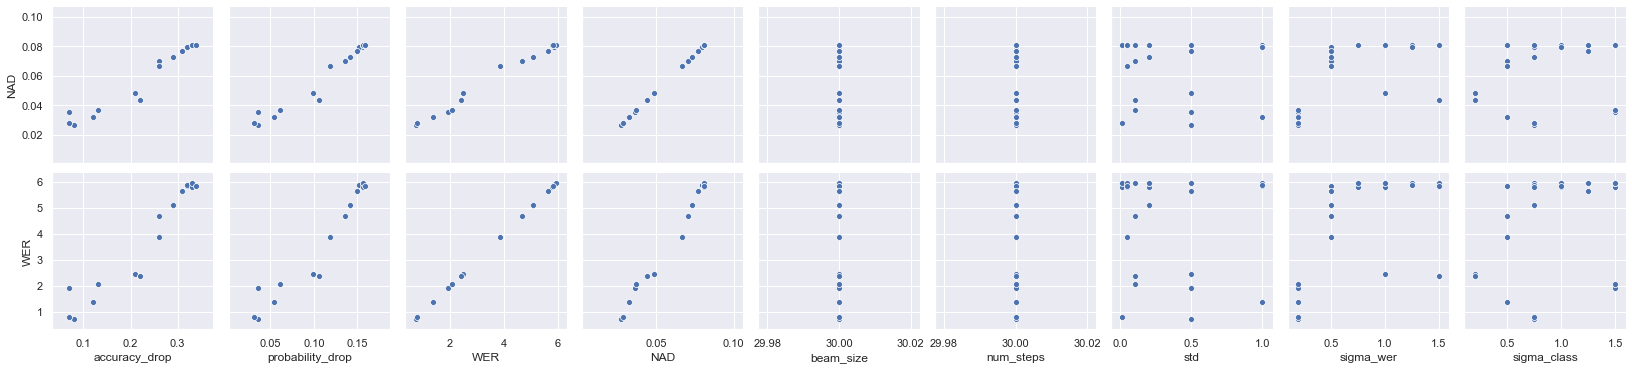

In [27]:
g = sns.pairplot(result, x_vars=result.columns.values, y_vars=['NAD', 'WER'])
plt.savefig(os.path.join(base_dir, f'stats_{method}.png'), dpi=150, bbox_inches='tight')

In [28]:
result.sort_values(by='NAD', ascending=False)

,accuracy_drop,probability_drop,WER,NAD,beam_size,num_steps,std,sigma_wer,sigma_class
0,0.33,0.156769,5.95,0.080844,30,30,1.00,0.75,1.00
10,0.33,0.155855,5.81,0.080844,30,30,0.01,0.75,1.50
28,0.34,0.158372,5.84,0.080844,30,30,0.05,1.50,0.50
27,0.33,0.156769,5.95,0.080844,30,30,0.05,1.00,1.25
23,0.33,0.156414,5.79,0.080844,30,30,0.05,1.00,0.75
22,0.33,0.156769,5.95,0.080844,30,30,0.20,0.75,1.50
18,0.33,0.156769,5.95,0.080844,30,30,0.10,1.50,1.00
16,0.33,0.156769,5.95,0.080844,30,30,0.50,1.00,1.50
14,0.33,0.156769,5.95,0.080844,30,30,0.01,1.25,0.75
11,0.33,0.156769,5.95,0.080844,30,30,0.10,1.00,1.00


In [31]:
result = []
for method in ['random']:
    base = os.path.join(base_dir, method)
    for folder in os.listdir(base):
        if folder != 'backup':
            args = json.load(open(os.path.join(base, folder, 'args.json')))
            metrics = json.load(open(os.path.join(base, folder, 'eval_metric.json')))
            args.update(metrics)
            result.append({k:args[k] for k in ['accuracy_drop', 'probability_drop', 'WER', 'NAD',
                                                'beam_size', 'num_steps', 'std']})
result = pd.DataFrame(result)

In [32]:
result.sort_values(by='NAD', ascending=False)

,accuracy_drop,probability_drop,WER,NAD,beam_size,num_steps,std
0,0.3,0.1436,7.49,0.082656,30,30,1.00
1,0.3,0.1436,7.49,0.082656,30,30,0.01
2,0.3,0.1436,7.49,0.082656,30,30,0.10
3,0.3,0.1436,7.49,0.082656,30,30,0.50
4,0.3,0.1436,7.49,0.082656,30,30,0.05
5,0.3,0.1436,7.49,0.082656,30,30,0.20


## make cascada grisearch

In [5]:
levenshtein_weights = [0.1, 1, 10]
beam_sizes = [1, 30, 100]
max_stepss = [5, 30, 100]
learning_rates = [1, 2, 4]

In [6]:
import itertools

In [7]:
params = list(itertools.product(levenshtein_weights, beam_sizes, max_stepss, learning_rates))

In [8]:
#dataset = 'insurance'

In [10]:
for p in tqdm(params):
    print(p)
    levenshtein_weight, beam_size, max_steps, learning_rate = p
    cmd = \
    f'''
    python run_cascada.py 
    --csv_path data/{dataset}/test.csv 
    --results_path results/{dataset}/cascada
    --classifier_path experiments/{dataset}/classification_copynet 
    --levenshtein_path experiments/{dataset}/deep_levenshtein_copynet 
    --copynet_path experiments/{dataset}/nonmasked_copynet_with_attention 
    --levenshtein_weight {levenshtein_weight}
    --beam_size {beam_size} 
    --max_steps {max_steps}
    --cuda 0 
    --num_updates 5 
    --learning_rate {learning_rate} 
    --sample 100
    '''.replace('\n','')
    #break
    result = subprocess.run(cmd, stdout=subprocess.PIPE, shell=True)

  0%|          | 0/81 [00:00<?, ?it/s]

(0.1, 1, 5, 1)


  1%|          | 1/81 [00:08<11:41,  8.77s/it]

(0.1, 1, 5, 2)


  2%|▏         | 2/81 [00:18<12:06,  9.19s/it]

(0.1, 1, 5, 4)


  4%|▎         | 3/81 [00:28<12:06,  9.31s/it]

(0.1, 1, 30, 1)


  5%|▍         | 4/81 [01:05<22:32, 17.56s/it]

(0.1, 1, 30, 2)


  6%|▌         | 5/81 [01:48<31:49, 25.13s/it]

(0.1, 1, 30, 4)


  7%|▋         | 6/81 [02:36<40:05, 32.07s/it]

(0.1, 1, 100, 1)


  9%|▊         | 7/81 [04:53<1:18:26, 63.60s/it]

(0.1, 1, 100, 2)


 10%|▉         | 8/81 [07:17<1:46:50, 87.82s/it]

(0.1, 1, 100, 4)


 11%|█         | 9/81 [10:01<2:12:50, 110.70s/it]

(0.1, 30, 5, 1)


 12%|█▏        | 10/81 [10:12<1:35:17, 80.53s/it]

(0.1, 30, 5, 2)


 14%|█▎        | 11/81 [10:24<1:09:57, 59.96s/it]

(0.1, 30, 5, 4)


 15%|█▍        | 12/81 [10:35<52:19, 45.50s/it]  

(0.1, 30, 30, 1)


 16%|█▌        | 13/81 [11:25<52:48, 46.60s/it]

(0.1, 30, 30, 2)


 17%|█▋        | 14/81 [12:22<55:32, 49.74s/it]

(0.1, 30, 30, 4)


 19%|█▊        | 15/81 [13:28<1:00:12, 54.74s/it]

(0.1, 30, 100, 1)


 20%|█▉        | 16/81 [16:23<1:38:27, 90.88s/it]

(0.1, 30, 100, 2)


 21%|██        | 17/81 [19:46<2:12:47, 124.50s/it]

(0.1, 30, 100, 4)


 22%|██▏       | 18/81 [23:32<2:42:30, 154.78s/it]

(0.1, 100, 5, 1)


 23%|██▎       | 19/81 [23:47<1:56:43, 112.96s/it]

(0.1, 100, 5, 2)


 25%|██▍       | 20/81 [24:01<1:24:47, 83.40s/it] 

(0.1, 100, 5, 4)


 26%|██▌       | 21/81 [24:18<1:03:24, 63.41s/it]

(0.1, 100, 30, 1)


 27%|██▋       | 22/81 [25:29<1:04:33, 65.64s/it]

(0.1, 100, 30, 2)


 28%|██▊       | 23/81 [26:51<1:08:11, 70.55s/it]

(0.1, 100, 30, 4)


 30%|██▉       | 24/81 [28:22<1:12:42, 76.54s/it]

(0.1, 100, 100, 1)


 31%|███       | 25/81 [32:47<2:04:21, 133.24s/it]

(0.1, 100, 100, 2)


 32%|███▏      | 26/81 [37:23<2:41:22, 176.04s/it]

(0.1, 100, 100, 4)


 33%|███▎      | 27/81 [42:26<3:12:39, 214.07s/it]

(1, 1, 5, 1)


 35%|███▍      | 28/81 [42:35<2:14:42, 152.50s/it]

(1, 1, 5, 2)


 36%|███▌      | 29/81 [42:46<1:35:25, 110.10s/it]

(1, 1, 5, 4)


 37%|███▋      | 30/81 [42:57<1:08:18, 80.37s/it] 

(1, 1, 30, 1)


 38%|███▊      | 31/81 [43:39<57:32, 69.06s/it]  

(1, 1, 30, 2)


 40%|███▉      | 32/81 [44:31<52:03, 63.74s/it]

(1, 1, 30, 4)


 41%|████      | 33/81 [45:26<48:57, 61.19s/it]

(1, 1, 100, 1)


 42%|████▏     | 34/81 [47:47<1:06:37, 85.06s/it]

(1, 1, 100, 2)


 43%|████▎     | 35/81 [50:23<1:21:41, 106.56s/it]

(1, 1, 100, 4)


 44%|████▍     | 36/81 [53:17<1:35:00, 126.68s/it]

(1, 30, 5, 1)


 46%|████▌     | 37/81 [53:29<1:07:41, 92.32s/it] 

(1, 30, 5, 2)


 47%|████▋     | 38/81 [53:41<48:47, 68.07s/it]  

(1, 30, 5, 4)


 48%|████▊     | 39/81 [53:53<35:59, 51.43s/it]

(1, 30, 30, 1)


 49%|████▉     | 40/81 [54:50<36:10, 52.95s/it]

(1, 30, 30, 2)


 51%|█████     | 41/81 [55:53<37:17, 55.93s/it]

(1, 30, 30, 4)


 52%|█████▏    | 42/81 [57:01<38:41, 59.53s/it]

(1, 30, 100, 1)


 53%|█████▎    | 43/81 [1:00:20<1:04:16, 101.50s/it]

(1, 30, 100, 2)


 54%|█████▍    | 44/81 [1:03:55<1:23:28, 135.37s/it]

(1, 30, 100, 4)


 56%|█████▌    | 45/81 [1:07:40<1:37:27, 162.44s/it]

(1, 100, 5, 1)


 57%|█████▋    | 46/81 [1:07:55<1:08:51, 118.04s/it]

(1, 100, 5, 2)


 58%|█████▊    | 47/81 [1:08:10<49:25, 87.21s/it]   

(1, 100, 5, 4)


 59%|█████▉    | 48/81 [1:08:26<36:16, 65.97s/it]

(1, 100, 30, 1)


 60%|██████    | 49/81 [1:09:48<37:46, 70.84s/it]

(1, 100, 30, 2)


 62%|██████▏   | 50/81 [1:11:16<39:09, 75.78s/it]

(1, 100, 30, 4)


 63%|██████▎   | 51/81 [1:12:46<40:00, 80.02s/it]

(1, 100, 100, 1)


 64%|██████▍   | 52/81 [1:17:26<1:07:46, 140.23s/it]

(1, 100, 100, 2)


 65%|██████▌   | 53/81 [1:22:21<1:27:01, 186.48s/it]

(1, 100, 100, 4)


 67%|██████▋   | 54/81 [1:27:33<1:40:55, 224.29s/it]

(10, 1, 5, 1)


 68%|██████▊   | 55/81 [1:27:44<1:09:24, 160.19s/it]

(10, 1, 5, 2)


 69%|██████▉   | 56/81 [1:27:55<48:09, 115.59s/it]  

(10, 1, 5, 4)


 70%|███████   | 57/81 [1:28:10<34:06, 85.27s/it] 

(10, 1, 30, 1)


 72%|███████▏  | 58/81 [1:29:05<29:10, 76.09s/it]

(10, 1, 30, 2)


 73%|███████▎  | 59/81 [1:30:06<26:13, 71.53s/it]

(10, 1, 30, 4)


 74%|███████▍  | 60/81 [1:31:08<24:03, 68.75s/it]

(10, 1, 100, 1)


 75%|███████▌  | 61/81 [1:34:11<34:24, 103.21s/it]

(10, 1, 100, 2)


 77%|███████▋  | 62/81 [1:37:20<40:48, 128.86s/it]

(10, 1, 100, 4)


 78%|███████▊  | 63/81 [1:40:33<44:26, 148.12s/it]

(10, 30, 5, 1)


 79%|███████▉  | 64/81 [1:40:46<30:25, 107.41s/it]

(10, 30, 5, 2)


 80%|████████  | 65/81 [1:41:00<21:12, 79.52s/it] 

(10, 30, 5, 4)


 81%|████████▏ | 66/81 [1:41:13<14:55, 59.67s/it]

(10, 30, 30, 1)


 83%|████████▎ | 67/81 [1:42:20<14:22, 61.62s/it]

(10, 30, 30, 2)


 84%|████████▍ | 68/81 [1:43:30<13:53, 64.14s/it]

(10, 30, 30, 4)


 85%|████████▌ | 69/81 [1:44:39<13:09, 65.83s/it]

(10, 30, 100, 1)


 86%|████████▋ | 70/81 [1:48:22<20:42, 112.93s/it]

(10, 30, 100, 2)


 88%|████████▊ | 71/81 [1:52:04<24:15, 145.51s/it]

(10, 30, 100, 4)


 89%|████████▉ | 72/81 [1:55:59<25:51, 172.40s/it]

(10, 100, 5, 1)


 90%|█████████ | 73/81 [1:56:17<16:48, 126.01s/it]

(10, 100, 5, 2)


 91%|█████████▏| 74/81 [1:56:33<10:52, 93.19s/it] 

(10, 100, 5, 4)


 93%|█████████▎| 75/81 [1:56:52<07:04, 70.83s/it]

(10, 100, 30, 1)


 94%|█████████▍| 76/81 [1:58:25<06:27, 77.44s/it]

(10, 100, 30, 2)


 95%|█████████▌| 77/81 [1:59:58<05:29, 82.33s/it]

(10, 100, 30, 4)


 96%|█████████▋| 78/81 [2:01:36<04:20, 86.94s/it]

(10, 100, 100, 1)


 98%|█████████▊| 79/81 [2:06:41<05:04, 152.25s/it]

(10, 100, 100, 2)


 99%|█████████▉| 80/81 [2:11:58<03:21, 201.76s/it]

(10, 100, 100, 4)


100%|██████████| 81/81 [2:17:13<00:00, 101.65s/it]


In [9]:
cmd

'    python run_cascada.py     --csv_path data/insurance/test.csv     --results_path results/insurance/cascada    --classifier_path experiments/insurance/classification_copynet     --levenshtein_path experiments/insurance/deep_levenshtein_copynet     --copynet_path experiments/insurance/nonmasked_copynet_with_attention     --levenshtein_weight 0.1    --beam_size 1     --max_steps 5    --cuda 0     --num_updates 5     --learning_rate 1     --sample 100    '

In [59]:
dataset = 'ag_news'

In [60]:
base_dir = f'results/{dataset}'

In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
model_with_weights = joblib.load(f'results/{dataset}/logit_tfidf.model')
model = model_with_weights['model']
w = model_with_weights['weights']
for method in ['cascada']:
    base = os.path.join(base_dir, method)
    for folder in os.listdir(base):
        if folder != 'backup':
            attack_results_path = f'{base}/{folder}/results.csv'
            eval_results_path = f'{base}/{folder}/eval_metric.json'
            df = pd.read_csv(attack_results_path)
            df.rename(columns={'generated_sequence':'adversarial_sequence'}, inplace=True)
            metrics = calculate_metrics(model, w, 
                                    df['label'].values, 
                                    df['sequence'].values,
                                    df['adversarial_sequence'].values)
            json.dump(metrics, open(eval_results_path, 'w'))

In [81]:
w

array([0.28425745, 0.32533471])

In [33]:
result = []
for method in ['cascada']:
    base = os.path.join(base_dir, method)
    for folder in os.listdir(base):
        if folder != 'backup':
            args = json.load(open(os.path.join(base, folder, 'args.json')))
            metrics = json.load(open(os.path.join(base, folder, 'eval_metric.json')))
            args.update(metrics)
            result.append({k:args[k] for k in ['roc_auc_drop', 'accuracy_drop', 'probability_drop', 'WER', 'NAD',
                                               'levenshtein_weight', 'beam_size', 'max_steps', 'learning_rate']})
result = pd.DataFrame(result)

In [34]:
base_dir

'results/kaggle_transactions'

In [35]:
sns.set()

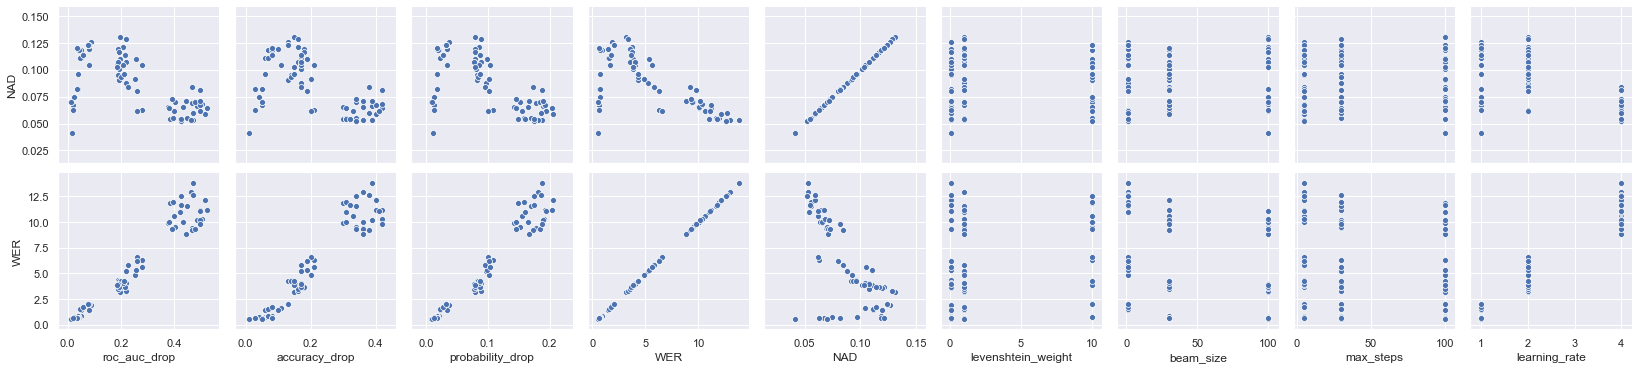

In [36]:
g = sns.pairplot(result, x_vars=result.columns.values, y_vars=['NAD', 'WER'])
plt.savefig(os.path.join(base_dir, f'stats_{method}.png'), dpi=150, bbox_inches='tight')

In [37]:
result.sort_values(by='NAD', ascending=False)

,roc_auc_drop,accuracy_drop,probability_drop,WER,NAD,levenshtein_weight,beam_size,max_steps,learning_rate
12,0.198068,0.15,0.079708,3.15,0.131213,1.0,100,100,2.0
18,0.220612,0.16,0.088647,3.34,0.128539,1.0,100,30,2.0
21,0.086151,0.13,0.037243,1.89,0.126397,0.1,1,5,1.0
38,0.077697,0.13,0.032681,2.03,0.123689,10.0,1,30,1.0
61,0.077697,0.13,0.032681,2.03,0.123689,10.0,1,100,1.0
...,...,...,...,...,...,...,...,...,...
54,0.424718,0.31,0.160928,10.95,0.054111,1.0,1,100,4.0
36,0.473833,0.39,0.188527,13.80,0.052994,0.1,1,5,4.0
49,0.464573,0.36,0.182050,12.94,0.052981,1.0,1,5,4.0
71,0.425926,0.34,0.174067,12.58,0.052413,10.0,1,5,4.0


In [39]:
result[(result['beam_size'] == 30)&(result['max_steps'] == 30)].sort_values(by='NAD', ascending=False)

,roc_auc_drop,accuracy_drop,probability_drop,WER,NAD,levenshtein_weight,beam_size,max_steps,learning_rate
24,0.036634,0.08,0.018509,0.66,0.120773,1.0,30,30,1.0
28,0.037440,0.07,0.017609,0.87,0.118357,10.0,30,30,1.0
58,0.215781,0.17,0.087077,3.68,0.114074,1.0,30,30,2.0
45,0.219002,0.17,0.088574,4.04,0.107491,0.1,30,30,2.0
26,0.040660,0.06,0.018633,0.74,0.096618,0.1,30,30,1.0
69,0.199678,0.14,0.083568,4.31,0.093495,10.0,30,30,2.0
80,0.499195,0.42,0.187886,9.79,0.081323,1.0,30,30,4.0
7,0.524155,0.42,0.204365,11.17,0.064954,0.1,30,30,4.0
22,0.383253,0.31,0.144962,10.05,0.064226,10.0,30,30,4.0


In [46]:
for dataset in ['ag_news', 'insurance', 'ai_academy_data', 'kaggle_transactions']:
    cmd = f"""
    python run_hotflip.py 
    --csv_path data/{dataset}/test.csv 
    --results_path results/{dataset}/hotflip
    --classifier_path experiments/{dataset}/classifier_basic 
    --sample 100
    """.replace('\n','')
    result = subprocess.run(cmd, stdout=subprocess.PIPE, shell=True)
    
    xs = os.listdir(f'results/{dataset}/hotflip')
    x = np.sort(xs)[-1]
    cmd = f"""
     python eval.py 
        -mp results/{dataset}/logit_tfidf.model 
        -arp results/{dataset}/hotflip/{x}/results.csv 
        -erp results/{dataset}/hotflip/{x}/eval_metric.json
    """.replace('\n','')
    result = subprocess.run(cmd, stdout=subprocess.PIPE, shell=True)
    print(result.stdout)

b"{'accuracy_drop': 0.81, 'roc_auc_drop': 0.812639142814872, 'probability_drop': 0.6869838213611057, 'WER': 6.41, 'NAD': 0.1676344408880983}\n"
b"{'accuracy_drop': 0.7, 'roc_auc_drop': 0.1717171717171717, 'probability_drop': 0.3148502648161993, 'WER': 5.45, 'NAD': 0.1300819570174395}\n"
b"{'accuracy_drop': 0.36, 'roc_auc_drop': 0.3680645069262523, 'probability_drop': 0.2128507382176137, 'WER': 8.77, 'NAD': 0.11854225796642669}\n"
b"{'accuracy_drop': 0.3499999999999999, 'roc_auc_drop': 0.3681561996779388, 'probability_drop': 0.20812382491394066, 'WER': 10.13, 'NAD': 0.09894366754297998}\n"
